In [1]:
# from src.hrv_epatch.io.tdms import extract_tdms_channel
from src.hrv_epatch.io.data_loader import Load_full_ecg_data

from __future__ import annotations

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

from scipy.signal import welch
from scipy import stats
from datetime import timedelta, datetime as dt

from src.hrv_epatch.io.data_loader import Load_full_ecg_data


@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float       # sekunder fra recording start
    t1: float       # sekunder fra recording start


In [2]:
data = Load_full_ecg_data("Patient 5")
patient_id = data["PatientID"]
ecg_df = data["ECG"]
seizure_df = data["Seizures"]
sample_rate = data["SampleRate"]


print(f"Loaded data for {patient_id}:")
print(f"- ECG signal shape: {ecg_df.shape}")
print(f"- Number of seizures: {seizure_df.shape[0]}")
print(f"- Sample rate: {sample_rate} Hz")

print(seizure_df.head())

start_ts = pd.to_datetime(data["StartTime"])
print("Recording start:", start_ts)

# Alternative
# start_ts = pd.to_datetime(ecg_df["Timestamp"].iloc[0])


[DEBUG] Potentielle annoteringsfiler for Patient 5:
    Patient 5.xls
  - Læser seizure-log fra: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed\Patient 5.xls
Loaded data for Patient 5:
- ECG signal shape: (82460288, 2)
- Number of seizures: 3
- Sample rate: 512.0 Hz
0  NaN Anfald nr.      Dato Anfaldsstart Klinisk (tt:mm:ss)  \
0  NaN          1  13.10.16                        07:26:57   
1  NaN          2  13.10.16                        14:47:50   
2  NaN          3  13.10.16                        15:36:28   

0 Anfaldsstart EEG (tt:mm:ss) Anfaldstop Klinisk (tt:mm:ss)  \
0                    07:26:31                      07:28:57   
1                    14:47:29                      14:49:23   
2                    15:36:30                      15:38:38   

0 Anfaldstop EEG (tt:mm:ss)       Anfaldstype Evt. bemærkninger  
0                  07:26:58  kompleks partiel             

In [3]:
seizure_events: List[SeizureEvent] = []

for _, row in seizure_df.iterrows():
    # Byg fulde datetime-stempler fra 'Dato' + tidstekst
    date_str = str(row["Dato"]).strip() if pd.notna(row["Dato"]) else None

    def parse_dt(time_str_col: str) -> Optional[pd.Timestamp]:
        if date_str is None or pd.isna(row[time_str_col]):
            return None
        timestr = str(row[time_str_col]).strip()
        # Tilpas format hvis nødvendigt (her antaget: dd.mm.yy HH:MM:SS)
        return pd.to_datetime(f"{date_str} {timestr}", format="%d.%m.%y %H:%M:%S", errors="coerce")

    start_klinisk = parse_dt("Anfaldsstart Klinisk (tt:mm:ss)")
    stop_klinisk  = parse_dt("Anfaldstop Klinisk (tt:mm:ss)")
    start_eeg     = parse_dt("Anfaldsstart EEG (tt:mm:ss)")
    stop_eeg      = parse_dt("Anfaldstop EEG (tt:mm:ss)")

    if start_klinisk is not None and stop_klinisk is not None:
        klinisk_duration = (stop_klinisk - start_klinisk).total_seconds()
    else:
        klinisk_duration = 0.0

    if start_eeg is not None and stop_eeg is not None:
        eeg_duration = (stop_eeg - start_eeg).total_seconds()
    else:
        eeg_duration = 0.0

    # Vælg hvilken annotation vi tror mest på (klinisk vs EEG)
    if klinisk_duration >= eeg_duration and start_klinisk is not None:
        t0_dt = start_klinisk
        duration = klinisk_duration
    elif start_eeg is not None:
        t0_dt = start_eeg
        duration = eeg_duration
    else:
        continue  # ingen valid annotation

    # Konverter til sekunder fra recording start
    t0 = (t0_dt - start_ts).total_seconds()
    t1 = t0 + duration

    if t1 <= t0:
        continue  # discard hvis duration er 0 eller negativ

    ev = SeizureEvent(
        seizure_id=int(row["Anfald nr."]),
        t0=t0,
        t1=t1,
    )
    seizure_events.append(ev)

print("Antal validerede seizure events:", len(seizure_events))
if seizure_events:
    print("Eksempler:", seizure_events[:3])


Antal validerede seizure events: 3
Eksempler: [SeizureEvent(seizure_id=1, t0=73315.0, t1=73435.0), SeizureEvent(seizure_id=2, t0=99747.0, t1=99862.0), SeizureEvent(seizure_id=3, t0=102686.0, t1=102816.0)]


In [4]:
# %%
# Ekstraher 1D-ECG-signal og optagelseslængde i sekunder
# Antag at ecg_df har en kolonne med selve signalværdien:
if "Value" in ecg_df.columns:
    ecg_signal = ecg_df["Value"].to_numpy(dtype=float)
elif "ECG" in ecg_df.columns:
    ecg_signal = ecg_df["ECG"].to_numpy(dtype=float)
else:
    # fallback: vælg første numeriske kolonne
    num_cols = ecg_df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        raise ValueError("Kunne ikke finde numeriske ECG-kolonner i ecg_df")
    ecg_signal = ecg_df[num_cols[0]].to_numpy(dtype=float)

fs = float(sample_rate)
rec_duration_s = len(ecg_signal) / fs
print(f"Recording duration: {rec_duration_s/3600:.2f} timer")


Recording duration: 44.74 timer


In [5]:
# %%
def extract_segment(
    x: np.ndarray,
    fs: float,
    t0: float,
    t1: float,
) -> np.ndarray:
    """Udtræk ECG-segment mellem t0–t1 sekunder (relativt til recording start)."""
    i0 = int(round(t0 * fs))
    i1 = int(round(t1 * fs))
    i0 = max(i0, 0)
    i1 = min(i1, len(x))
    return x[i0:i1]


In [6]:
def compute_psd_features(
    x_seg: np.ndarray,
    fs: float,
    bands: Optional[Dict[str, Tuple[float, float]]] = None,
) -> Dict[str, float]:
    """
    Beregn simple spektre-features på et 1D ECG-segment (Welch).
    Returnerer total power + bånd-power + relativ bånd-power.
    """
    if bands is None:
        bands = {
            "band_0_5_5": (0.5, 5.0),
            "band_5_15": (5.0, 15.0),
            "band_15_40": (15.0, 40.0),
        }

    if len(x_seg) < 2 * fs:  # for kort segment
        base = {"total_power": np.nan}
        for name in bands:
            base[f"{name}_power"] = np.nan
            base[f"{name}_rel_power"] = np.nan
        return base

    nperseg = min(4 * int(fs), len(x_seg))
    f, Pxx = welch(x_seg, fs=fs, nperseg=nperseg)

    features: Dict[str, float] = {}
    total_power = np.trapz(Pxx, f)
    features["total_power"] = total_power

    for name, (f_lo, f_hi) in bands.items():
        mask = (f >= f_lo) & (f <= f_hi)
        if not np.any(mask):
            band_power = np.nan
        else:
            band_power = np.trapz(Pxx[mask], f[mask])
        features[f"{name}_power"] = band_power
        features[f"{name}_rel_power"] = (
            band_power / total_power if total_power > 0 else np.nan
        )

    return features

def csi_modcsi(rr: np.ndarray) -> Tuple[float, float]:
    """
    Beregn CSI og ModCSI ud fra RR-intervaller (sekunder)
    via Poincaré SD1 og SD2 (Jeppesen-definition).
    """
    if len(rr) < 4:
        return np.nan, np.nan

    diff = np.diff(rr)
    summ = rr[:-1] + rr[1:]

    sd1 = np.std((np.sqrt(2) / 2.0) * diff, ddof=1)
    sd2 = np.std((np.sqrt(2) / 2.0) * summ, ddof=1)

    T = 4 * sd1
    L = 4 * sd2

    if T == 0:
        return np.nan, np.nan

    csi = L / T
    modcsi = (L ** 2) / T
    return csi, modcsi

def tachogram_slope(rr: np.ndarray, times: Optional[np.ndarray] = None) -> float:
    """
    Beregn lineær slope af tachogram (RR vs tid eller indeks).
    """
    if len(rr) < 4:
        return np.nan

    if times is None:
        x = np.arange(len(rr))
    else:
        x = np.asarray(times)
        if x.shape != rr.shape:
            raise ValueError("times og rr skal have samme længde")

    slope, _, _, _, _ = stats.linregress(x, rr)
    return slope

def compute_hrv_features(
    rr_times: Optional[np.ndarray],
    rr_intervals: Optional[np.ndarray],
    t0: float,
    t1: float,
) -> Dict[str, float]:
    """
    Beregn HRV/CSI/ModCSI/slope-features for RR-intervaler indenfor [t0, t1].

    Hvis rr_times eller rr_intervals er None, returneres NaN for alle HRV-features,
    så scriptet stadig kan køre uden at HRV-delen er koblet på endnu.
    """
    if rr_times is None or rr_intervals is None:
        return {
            "rr_mean": np.nan,
            "rr_std": np.nan,
            "hr_mean": np.nan,
            "hr_std": np.nan,
            "csi": np.nan,
            "modcsi": np.nan,
            "slope": np.nan,
            "modcsi_x_slope": np.nan,
        }

    rr_times = np.asarray(rr_times)
    rr_intervals = np.asarray(rr_intervals)

    mask = (rr_times >= t0) & (rr_times <= t1)
    rr_win = rr_intervals[mask]
    t_win = rr_times[mask]

    if rr_win.size < 10:
        return {
            "rr_mean": np.nan,
            "rr_std": np.nan,
            "hr_mean": np.nan,
            "hr_std": np.nan,
            "csi": np.nan,
            "modcsi": np.nan,
            "slope": np.nan,
            "modcsi_x_slope": np.nan,
        }

    rr_mean = float(np.mean(rr_win))
    rr_std = float(np.std(rr_win, ddof=1))
    hr = 60.0 / rr_win
    hr_mean = float(np.mean(hr))
    hr_std = float(np.std(hr, ddof=1))

    csi, modcsi = csi_modcsi(rr_win)
    slope = tachogram_slope(rr_win, t_win)

    return {
        "rr_mean": rr_mean,
        "rr_std": rr_std,
        "hr_mean": hr_mean,
        "hr_std": hr_std,
        "csi": csi,
        "modcsi": modcsi,
        "slope": slope,
        "modcsi_x_slope": (
            modcsi * slope if np.isfinite(modcsi) and np.isfinite(slope) else np.nan
        ),
    }


In [7]:
# %%
def build_feature_table_for_patient(
    patient_id: str,
    ecg_signal: np.ndarray,
    fs: float,
    seizure_events: List[SeizureEvent],
    rr_times: Optional[np.ndarray] = None,
    rr_intervals: Optional[np.ndarray] = None,
    baseline_offset: float = 3600.0,  # fx 1 time efter seizure-start
) -> pd.DataFrame:
    """
    Byg en feature-tabel (seizure + baseline) for en patient.

    - Bruger dine SeizureEvent (t0, t1 i sek fra recording start)
    - Ekstraherer ECG-segmenter for seizure + baseline
    - Beregner frekvens-features (PSD) + HRV-features (hvis RR angives)
    """
    rows = []
    rec_duration_s = len(ecg_signal) / fs

    for ev in seizure_events:
        dur = ev.t1 - ev.t0

        # --- Seizure-segment ---
        x_seiz = extract_segment(ecg_signal, fs, ev.t0, ev.t1)
        psd_seiz = compute_psd_features(x_seiz, fs)
        hrv_seiz = compute_hrv_features(rr_times, rr_intervals, ev.t0, ev.t1)

        row_seiz = {
            "patient_id": patient_id,
            "seizure_id": ev.seizure_id,
            "segment_type": "seizure",
            "t0": ev.t0,
            "t1": ev.t1,
            "duration_s": dur,
        }
        row_seiz.update(psd_seiz)
        row_seiz.update(hrv_seiz)
        rows.append(row_seiz)

        # --- Baseline-segment (samme længde, forskudt i tid) ---
        base_t0 = ev.t0 + baseline_offset
        base_t1 = base_t0 + dur

        if base_t1 <= rec_duration_s:
            x_base = extract_segment(ecg_signal, fs, base_t0, base_t1)
            psd_base = compute_psd_features(x_base, fs)
            hrv_base = compute_hrv_features(rr_times, rr_intervals, base_t0, base_t1)

            row_base = {
                "patient_id": patient_id,
                "seizure_id": ev.seizure_id,
                "segment_type": "baseline",
                "t0": base_t0,
                "t1": base_t1,
                "duration_s": dur,
            }
            row_base.update(psd_base)
            row_base.update(hrv_base)
            rows.append(row_base)

    return pd.DataFrame(rows)


In [8]:
# %%
# TODO: hvis du har RR-data i 'data', kan du koble dem på her.
# Eksempel (tilpas kolonnenavne til din faktiske struktur):
rr_times = None
rr_intervals = None

# Hvis du har noget ala:
# rr_df = data["RR"]
# rr_times = rr_df["Time_s"].to_numpy()
# rr_intervals = rr_df["RR_s"].to_numpy()

df_features = build_feature_table_for_patient(
    patient_id=patient_id,
    ecg_signal=ecg_signal,
    fs=fs,
    seizure_events=seizure_events,
    rr_times=rr_times,
    rr_intervals=rr_intervals,
    baseline_offset=-1200.0,
)

print(df_features.head())
print(df_features.segment_type.value_counts())


  patient_id  seizure_id segment_type        t0        t1  duration_s  \
0  Patient 5           1      seizure   73315.0   73435.0       120.0   
1  Patient 5           1     baseline   72115.0   72235.0       120.0   
2  Patient 5           2      seizure   99747.0   99862.0       115.0   
3  Patient 5           2     baseline   98547.0   98662.0       115.0   
4  Patient 5           3      seizure  102686.0  102816.0       130.0   

     total_power  band_0_5_5_power  band_0_5_5_rel_power  band_5_15_power  \
0  178516.704293      53407.846031              0.299176     64360.247342   
1   45842.912442      17735.071975              0.386866     19387.573790   
2  441276.060907     117094.331586              0.265354     98579.661939   
3   74041.469764      24128.016092              0.325872     32534.452736   
4  946780.851518     406912.467162              0.429785     66747.063164   

   ...  band_15_40_power  band_15_40_rel_power  rr_mean  rr_std  hr_mean  \
0  ...      21761.0209

In [9]:
# %%
out_path = f"./_analysis/{patient_id}_seizure_baseline_features.csv"
import os
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_features.to_csv(out_path, index=False)
print("Saved feature table to:", out_path)


Saved feature table to: ./_analysis/Patient 5_seizure_baseline_features.csv


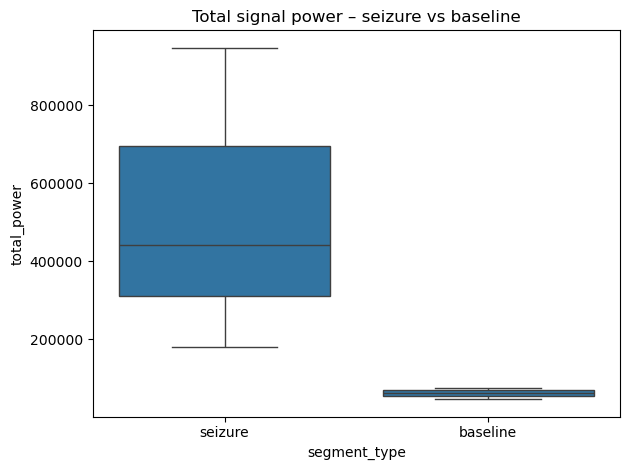

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df_features, x="segment_type", y="total_power")
plt.title("Total signal power – seizure vs baseline")
plt.tight_layout()
plt.show()


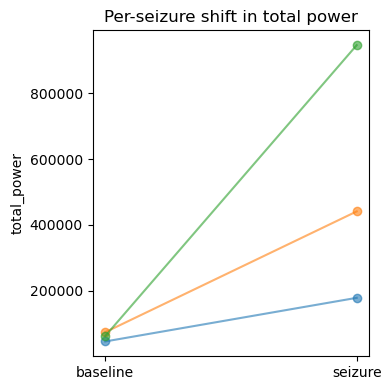

In [41]:
df_wide = df_features.pivot_table(
    index="seizure_id",
    columns="segment_type",
    values="total_power"
).reset_index()

plt.figure(figsize=(4,4))
for _, r in df_wide.iterrows():
    plt.plot(["baseline", "seizure"], [r["baseline"], r["seizure"]], "-o", alpha=0.6)
plt.title("Per-seizure shift in total power")
plt.ylabel("total_power")
plt.tight_layout()
plt.show()


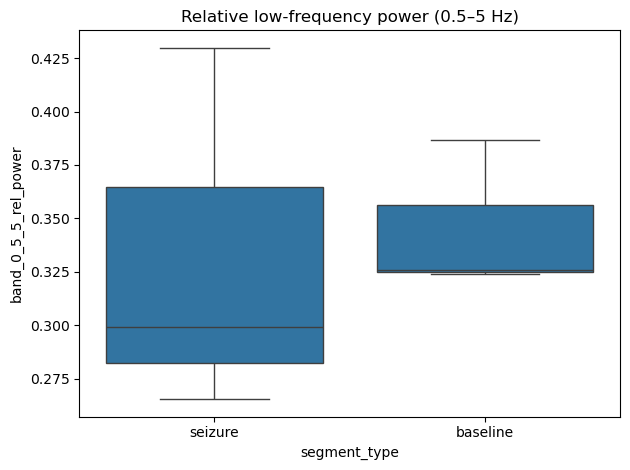

In [42]:
sns.boxplot(
    data=df_features,
    x="segment_type",
    y="band_0_5_5_rel_power"
)
plt.title("Relative low-frequency power (0.5–5 Hz)")
plt.tight_layout()
plt.show()


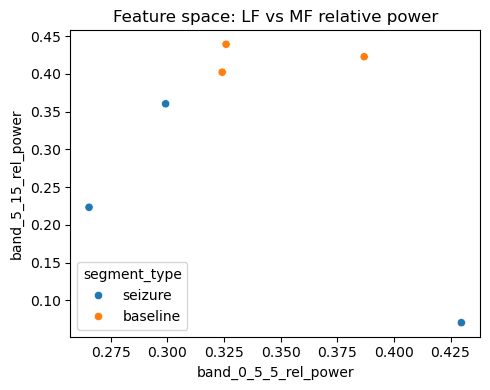

In [43]:
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=df_features,
    x="band_0_5_5_rel_power",
    y="band_5_15_rel_power",
    hue="segment_type"
)
plt.title("Feature space: LF vs MF relative power")
plt.tight_layout()
plt.show()


In [15]:
print(seizure_events)

[SeizureEvent(seizure_id=1, t0=73315.0, t1=73435.0), SeizureEvent(seizure_id=2, t0=99747.0, t1=99862.0), SeizureEvent(seizure_id=3, t0=102686.0, t1=102816.0)]


In [16]:
import numpy as np
from typing import List

def extract_segment(ecg: np.ndarray, fs: float, t_start: float, duration_s: float) -> np.ndarray:
    """
    Klip et [t_start, t_start + duration_s] vindue ud af ecg.
    Tid i sekunder fra recording-start.
    """
    n0 = int(round(t_start * fs))
    n1 = int(round((t_start + duration_s) * fs))
    n0 = max(n0, 0)
    n1 = min(n1, len(ecg))
    if n1 <= n0:
        return np.array([], dtype=float)
    return ecg[n0:n1]

from dataclasses import dataclass

@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float  # seconds
    t1: float  # seconds


def make_segments_for_patient(
    ecg: np.ndarray,
    fs: float,
    events: List[SeizureEvent],
    baseline_offset_s: float = 20 * 60.0,  # 20 min før
    baseline_gap_s: float = 60.0,          # undgå 1 min lige op til anfald
    seg_len_s: float = 10.0,
    seg_step_s: float = 10.0,              # ingen overlap; sæt fx 5.0 for 50% overlap
):
    baseline_segments: List[np.ndarray] = []
    seizure_segments: List[np.ndarray] = []

    for ev in events:
        # --- Baselineområde: [t0 - baseline_offset_s, t0 - baseline_gap_s]
        baseline_start = ev.t0 - baseline_offset_s
        baseline_end = ev.t0 - baseline_gap_s

        t = baseline_start
        while t + seg_len_s <= baseline_end:
            seg = extract_segment(ecg, fs, t_start=t, duration_s=seg_len_s)
            if seg.size > 0:
                baseline_segments.append(seg)
            t += seg_step_s

        # --- Seizureområde: [t0, t1]
        t = ev.t0
        while t < ev.t1:
            # sørg for vi ikke går længere end t1; her klipper vi bare til kanten
            seg_duration = min(seg_len_s, ev.t1 - t)
            if seg_duration <= 0:
                break
            seg = extract_segment(ecg, fs, t_start=t, duration_s=seg_duration)
            if seg.size > 0:
                seizure_segments.append(seg)
            t += seg_step_s

    return baseline_segments, seizure_segments


In [17]:
baseline_segments, seizure_segments = make_segments_for_patient(ecg_signal, fs, seizure_events)
print(len(baseline_segments), len(seizure_segments))

342 37


In [19]:
import numpy as np
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_for_many_segments,
    estimate_sqi_thresholds_from_population,
    classify_many_segments,
)

fs = 512.0
config = SQIConfig(fs=fs)

# 1) Lav segmenter
baseline_segments, seizure_segments = make_segments_for_patient(ecg_signal, fs, seizure_events)

# 2) Beregn features for baseline + seizures
baseline_feats = compute_sqi_for_many_segments(baseline_segments, config=config)
seizure_feats = compute_sqi_for_many_segments(seizure_segments, config=config)

# 3) Estimér thresholds hovedsageligt ud fra baseline (non-seizure)
thresholds = estimate_sqi_thresholds_from_population(baseline_feats)

# 4) Klassificér seizure-segmenterne
seizure_results = classify_many_segments(
    seizure_segments, config=config, thresholds=thresholds
)

n_good = sum(int(r["is_good"]) for r in seizure_results)
print(f"{n_good}/{len(seizure_results)} seizure-vinduer vurderes som teknisk brugbare.")


19/37 seizure-vinduer vurderes som teknisk brugbare.


In [21]:
import pandas as pd

df_seizure = pd.DataFrame(seizure_results)

# Kig på de vigtigste kolonner
cols = [
    "is_good",
    "sqi_score",
    "feat_ampdiff",
    "feat_mean_freq",
    "feat_hf_rel_power",
    "feat_lf_rel_power",
    "feat_flat_rampdiff_min",
]
print(df_seizure[cols])

# Sortér efter SQI (så du ser de værste segmenter først)
print(df_seizure[cols].sort_values("sqi_score"))


    is_good  sqi_score  feat_ampdiff  feat_mean_freq  feat_hf_rel_power  \
0     False   0.833333   3036.801587        5.620862           0.002672   
1      True   1.000000   2383.696345        6.964080           0.004577   
2      True   1.000000   2080.567330        9.130811           0.004125   
3      True   1.000000   4778.415564        5.219908           0.002803   
4      True   1.000000   5329.559228        7.813793           0.003452   
5     False   0.666667   5781.497032        7.778847           0.015880   
6      True   1.000000   2912.794263        8.597654           0.004225   
7      True   1.000000   4265.851957        8.514452           0.004838   
8      True   1.000000   3786.356970        7.886850           0.003721   
9     False   0.833333   4356.790661        7.897528           0.020137   
10     True   1.000000   3621.013870        9.565266           0.003530   
11     True   1.000000   4618.583902        6.081758           0.002153   
12     True   1.000000   

In [22]:
from dataclasses import dataclass
from typing import List, Literal

LabelType = Literal["baseline", "seizure"]

@dataclass
class LabeledSegment:
    data: np.ndarray
    label: LabelType
    seizure_id: int
    t_start: float
    t_end: float


def make_labeled_segments_for_patient(
    ecg: np.ndarray,
    fs: float,
    events: List[SeizureEvent],
    baseline_offset_s: float = 20 * 60.0,
    baseline_gap_s: float = 60.0,
    seg_len_s: float = 10.0,
    seg_step_s: float = 10.0,
) -> List[LabeledSegment]:
    segments: List[LabeledSegment] = []

    for ev in events:
        # Baseline
        baseline_start = ev.t0 - baseline_offset_s
        baseline_end = ev.t0 - baseline_gap_s

        t = baseline_start
        while t + seg_len_s <= baseline_end:
            seg = extract_segment(ecg, fs, t_start=t, duration_s=seg_len_s)
            if seg.size > 0:
                segments.append(
                    LabeledSegment(
                        data=seg,
                        label="baseline",
                        seizure_id=ev.seizure_id,
                        t_start=t,
                        t_end=t + seg_len_s,
                    )
                )
            t += seg_step_s

        # Seizure
        t = ev.t0
        while t < ev.t1:
            dur = min(seg_len_s, ev.t1 - t)
            if dur <= 0:
                break
            seg = extract_segment(ecg, fs, t_start=t, duration_s=dur)
            if seg.size > 0:
                segments.append(
                    LabeledSegment(
                        data=seg,
                        label="seizure",
                        seizure_id=ev.seizure_id,
                        t_start=t,
                        t_end=t + dur,
                    )
                )
            t += seg_step_s

    return segments


In [23]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
    classify_segment_with_thresholds,
)

segments = make_labeled_segments_for_patient(ecg_signal, fs, seizure_events)

config = SQIConfig(fs=fs)

rows = []
for seg in segments:
    feats = compute_sqi_features_for_segment(seg.data, config=config)
    res = classify_segment_with_thresholds(feats, thresholds=thresholds)
    row = {
        "label": seg.label,
        "seizure_id": seg.seizure_id,
        "t_start": seg.t_start,
        "t_end": seg.t_end,
    }
    row.update(res)
    rows.append(row)

df = pd.DataFrame(rows)

# Se kun seizure-segmenter
df_seizure = df[df["label"] == "seizure"]

# Fx: se de dårligste 10 segmenter
cols_view = [
    "seizure_id",
    "t_start",
    "is_good",
    "sqi_score",
    "feat_ampdiff",
    "feat_mean_freq",
    "feat_hf_rel_power",
    "feat_lf_rel_power",
]
print(df_seizure[cols_view].sort_values("sqi_score").head(10))


     seizure_id   t_start  is_good  sqi_score  feat_ampdiff  feat_mean_freq  \
378           3  102806.0    False   0.500000   3932.410040       14.950359   
376           3  102786.0    False   0.500000   6779.067063       28.864956   
375           3  102776.0    False   0.500000   7682.942672       18.851272   
249           2   99837.0    False   0.666667   9487.938170        2.122554   
247           2   99817.0    False   0.666667   4557.958099       18.893481   
377           3  102796.0    False   0.666667   5186.261875       23.009921   
245           2   99797.0    False   0.666667   4180.424689       12.562092   
244           2   99787.0    False   0.666667   3918.631449        9.937914   
246           2   99807.0    False   0.666667   4351.279225       20.551067   
119           1   73365.0    False   0.666667   5781.497032        7.778847   

     feat_hf_rel_power  feat_lf_rel_power  
378           0.082456           0.039894  
376           0.257852           0.015665 

In [24]:
import matplotlib.pyplot as plt
from typing import List, Dict
import numpy as np


def plot_good_and_bad_segments(
    segments: List[np.ndarray],
    results: List[Dict[str, object]],
    fs: float,
    n_good: int = 3,
    n_bad: int = 3,
):
    """
    Plot et udvalg af gode og dårlige segmenter baseret på is_good og sqi_score.

    segments : liste af 1D numpy-arrays (samme rækkefølge som results)
    results  : liste af dicts fra classify_segment_with_thresholds
    fs       : sampling rate [Hz]
    """

    # Find indeks for gode og dårlige segmenter
    good_idx = [i for i, r in enumerate(results) if r.get("is_good", False)]
    bad_idx = [i for i, r in enumerate(results) if not r.get("is_good", False)]

    # Sortér efter SQI-score så vi får de "mest" gode og "mest" dårlige
    good_idx = sorted(
        good_idx,
        key=lambda i: results[i].get("sqi_score", 0.0),
        reverse=True,
    )[:n_good]
    bad_idx = sorted(
        bad_idx,
        key=lambda i: results[i].get("sqi_score", 1.0),
    )[:n_bad]

    to_plot = [("GOOD", i) for i in good_idx] + [("BAD", i) for i in bad_idx]

    if not to_plot:
        print("Ingen segmenter at plotte.")
        return

    n_rows = len(to_plot)
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 2 * n_rows), sharex=False)
    if n_rows == 1:
        axes = [axes]

    for ax, (label, idx) in zip(axes, to_plot):
        seg = np.asarray(segments[idx], dtype=float)
        t = np.arange(len(seg)) / fs
        res = results[idx]
        sqi = res.get("sqi_score", np.nan)

        ax.plot(t, seg)
        ax.set_ylabel("ECG")
        ax.set_title(f"{label} seg {idx} | SQI={sqi:.2f}")
        ax.grid(True, which="both", linestyle="--", alpha=0.3)

    axes[-1].set_xlabel("Tid [s]")
    fig.tight_layout()
    plt.show()


19/37 seizure-vinduer vurderes som teknisk brugbare.


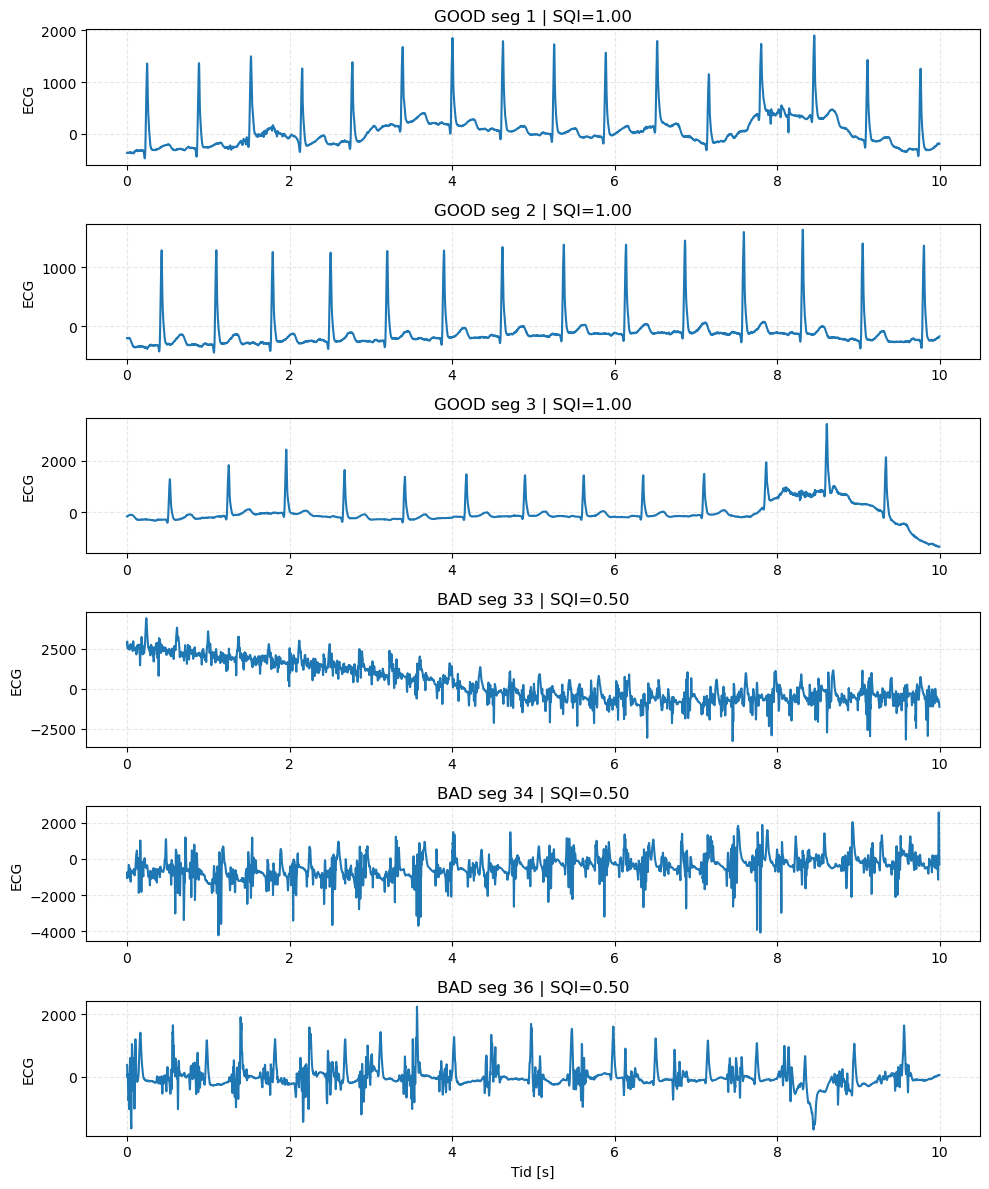

In [26]:
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
    estimate_sqi_thresholds_from_population,
    classify_segment_with_thresholds,
)

fs = 512.0
config = SQIConfig(fs=fs)

# Antag du allerede har:
# baseline_segments: List[np.ndarray]
# seizure_segments:  List[np.ndarray]

# 1) Beregn features for baseline (til thresholds)
baseline_feats = [compute_sqi_features_for_segment(seg, config) for seg in baseline_segments]

# 2) Estimer thresholds
thresholds = estimate_sqi_thresholds_from_population(baseline_feats)

# 3) Beregn features + klassifikation for seizure-segmenter
seizure_results = []
for seg in seizure_segments:
    feats = compute_sqi_features_for_segment(seg, config)
    res = classify_segment_with_thresholds(feats, thresholds)
    seizure_results.append(res)

print(f"{sum(int(r['is_good']) for r in seizure_results)}/{len(seizure_results)} seizure-vinduer vurderes som teknisk brugbare.")

# 4) Plot gode og dårlige segmenter
plot_good_and_bad_segments(seizure_segments, seizure_results, fs=fs, n_good=3, n_bad=3)


In [27]:
from dataclasses import dataclass
from typing import List

import numpy as np


@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float  # sek fra recording start
    t1: float  # sek fra recording start


@dataclass
class GlobalWindow:
    t_start: float
    t_end: float
    is_seizure: bool
    seizure_id: int | None
    data: np.ndarray


def window_overlaps_seizure(
    t_start: float,
    t_end: float,
    events: List[SeizureEvent],
) -> tuple[bool, int | None]:
    """Returnér (True/False, seizure_id) hvis vinduet overlapper et anfald."""
    for ev in events:
        # overlap hvis intervallerne skærer hinanden
        latest_start = max(t_start, ev.t0)
        earliest_end = min(t_end, ev.t1)
        if earliest_end > latest_start:
            return True, ev.seizure_id
    return False, None


def make_global_windows(
    ecg: np.ndarray,
    fs: float,
    events: List[SeizureEvent],
    seg_len_s: float = 10.0,
    seg_step_s: float = 10.0,
) -> List[GlobalWindow]:
    """
    Del hele signalet op i faste vinduer og markér seizure vs non-seizure.

    ecg      : fuldt 1D signal
    fs       : sampling rate [Hz]
    events   : liste af SeizureEvent
    seg_len_s: vindueslængde [s]
    seg_step_s: skridt [s]
    """
    n = len(ecg)
    T = n / fs

    windows: List[GlobalWindow] = []
    t = 0.0
    while t + seg_len_s <= T:
        t_start = t
        t_end = t + seg_len_s

        n0 = int(round(t_start * fs))
        n1 = int(round(t_end * fs))
        seg = ecg[n0:n1]

        is_seiz, seiz_id = window_overlaps_seizure(t_start, t_end, events)

        windows.append(
            GlobalWindow(
                t_start=t_start,
                t_end=t_end,
                is_seizure=is_seiz,
                seizure_id=seiz_id,
                data=seg,
            )
        )
        t += seg_step_s

    return windows


In [29]:
import pandas as pd
from src.hrv_epatch.sqi.sqi_bukhari import (
    SQIConfig,
    compute_sqi_features_for_segment,
    estimate_sqi_thresholds_from_population,
    classify_segment_with_thresholds,
)

fs = 512.0
config = SQIConfig(fs=fs)

# Antag du har:
# ecg: np.ndarray  (fuldt signal for én patient)
# events: List[SeizureEvent]

# 1) Lav globale vinduer
windows = make_global_windows(ecg_signal, fs, seizure_events, seg_len_s=10.0, seg_step_s=10.0)

# 2) Beregn features for ALLE vinduer
all_feats = [compute_sqi_features_for_segment(w.data, config) for w in windows]

# 3) Estimér thresholds KUN på non-seizure vinduer (så vi ikke "straffer" anfald)
non_seiz_feats = [
    f for f, w in zip(all_feats, windows) if not w.is_seizure
]
thresholds = estimate_sqi_thresholds_from_population(non_seiz_feats)

# 4) Klassificér alle vinduer
rows = []
for w, feats in zip(windows, all_feats):
    res = classify_segment_with_thresholds(feats, thresholds=thresholds)
    row = {
        "t_start": w.t_start,
        "t_end": w.t_end,
        "is_seizure": w.is_seizure,
        "seizure_id": w.seizure_id,
    }
    row.update(res)
    rows.append(row)

df_sqi = pd.DataFrame(rows)


In [30]:
# Samlet
n_total = len(df_sqi)
n_good = int(df_sqi["is_good"].sum())
print(f"Globalt: {n_good}/{n_total} vinduer er 'good' ({100*n_good/n_total:.1f} %)")

# Kun non-seizure
df_non = df_sqi[~df_sqi["is_seizure"]]
n_non = len(df_non)
n_non_good = int(df_non["is_good"].sum())
print(f"Non-seizure: {n_non_good}/{n_non} vinduer 'good' ({100*n_non_good/n_non:.1f} %)")

# Kun seizure
df_seiz = df_sqi[df_sqi["is_seizure"]]
n_seiz = len(df_seiz)
n_seiz_good = int(df_seiz["is_good"].sum())
print(f"Seizure: {n_seiz_good}/{n_seiz} vinduer 'good' ({100*n_seiz_good/n_seiz:.1f} %)")


Globalt: 14721/16105 vinduer er 'good' (91.4 %)
Non-seizure: 14687/16065 vinduer 'good' (91.4 %)
Seizure: 34/40 vinduer 'good' (85.0 %)


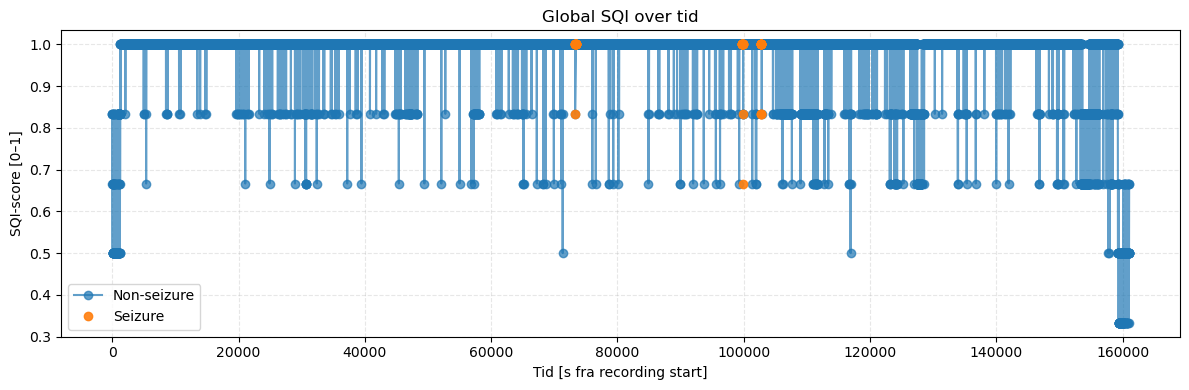

In [31]:
import matplotlib.pyplot as plt

def plot_global_sqi_over_time(df_sqi: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(12, 4))

    # Non-seizure
    df_non = df_sqi[~df_sqi["is_seizure"]]
    ax.plot(
        df_non["t_start"],
        df_non["sqi_score"],
        marker="o",
        linestyle="-",
        alpha=0.7,
        label="Non-seizure",
    )

    # Seizure
    df_seiz = df_sqi[df_sqi["is_seizure"]]
    if not df_seiz.empty:
        ax.plot(
            df_seiz["t_start"],
            df_seiz["sqi_score"],
            marker="o",
            linestyle="",
            alpha=0.9,
            label="Seizure",
        )

    ax.set_xlabel("Tid [s fra recording start]")
    ax.set_ylabel("SQI-score [0–1]")
    ax.set_title("Global SQI over tid")
    ax.grid(True, which="both", linestyle="--", alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()

# Brug:
plot_global_sqi_over_time(df_sqi)


In [32]:
# import numpy as np
# from src.hrv_epatch.sqi.sqi_bukhari import (
#     SQIConfig,
#     compute_sqi_for_many_segments,
#     estimate_sqi_thresholds_from_population,
#     classify_many_segments,
# )

# fs = 512.0
# config = SQIConfig(fs=fs)

# # 1) Lav segmenter
# baseline_segments, seizure_segments = make_segments_for_patient(ecg_signal, fs, seizure_events)

# # 2) Beregn features for baseline + seizures
# baseline_feats = compute_sqi_for_many_segments(baseline_segments, config=config)
# seizure_feats = compute_sqi_for_many_segments(seizure_segments, config=config)

# # 3) Estimér thresholds hovedsageligt ud fra baseline (non-seizure)
# thresholds = estimate_sqi_thresholds_from_population(baseline_feats)

# # 4) Klassificér seizure-segmenterne
# seizure_results = classify_many_segments(
#     seizure_segments, config=config, thresholds=thresholds
# )

# n_good = sum(int(r["is_good"]) for r in seizure_results)
# print(f"{n_good}/{len(seizure_results)} seizure-vinduer vurderes som teknisk brugbare.")


,feat_ampdiff,feat_mean_freq,feat_hf_rel_power
is_seizure,,,
False,2521.025291,8.932967,0.013625
True,4701.668809,9.215710,0.027377


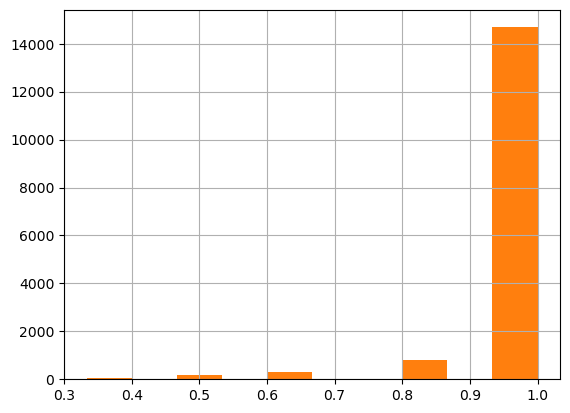

In [34]:
df_sqi[df_sqi["is_seizure"]]["sqi_score"].hist()
df_sqi[~df_sqi["is_seizure"]]["sqi_score"].hist()
df_sqi.groupby("is_seizure")[["feat_ampdiff", "feat_mean_freq", "feat_hf_rel_power"]].mean()
